# NBA Network Dynamics Analysis
This notebook reproduces the full workflow from the cleaned project: loading data, constructing team and player metrics, building the event-study panel, and generating RQ1–RQ3 visualizations.

In [1]:
import pandas as pd
import numpy as np

from pbp_loader import load_pbp
from player_events import make_player_events
from stars import compute_player_usage, flag_team_stars
from team_games import build_team_games
from appearances_and_departures import (
    build_player_game_appearances,
    build_star_games,
    detect_departures,
    summarize_departures,
)
from outcomes import compute_team_outcomes
from quick_metrics import compute_team_assists_per_game
from network_metrics import build_team_passing_edges, compute_passing_network_metrics
from event_study import build_departure_event_panel

# Visualization modules
from viz_rq1 import plot_rq1_histograms, plot_rq1_scatter_relations
from viz_rq2 import plot_rq2_ci, plot_rq2_facets, plot_rq2_pre_post
from viz_rq3 import plot_rq3_logit_coefficients, plot_rq3_feature_importance

## 1. Load Play-by-Play Data

In [2]:
pbp = load_pbp("NBA-Data")
pbp.head()

,URL,GameType,Location,Date,Time,WinningTeam,Quarter,SecLeft,AwayTeam,AwayPlay,...,TurnoverCause,TurnoverCauser,JumpballAwayPlayer,JumpballHomePlayer,JumpballPoss,Unnamed: 40,game_id,season_start_year,season,event_team
0,/boxscores/201510270ATL.html,regular,Philips Arena Atlanta Georgia,October 27 2015,8:00 PM,DET,1,720,DET,Jump ball: A. Drummond vs. A. Horford (E. lyas...,...,NaN,NaN,A. Drummond - drumman01,A. Horford - horfoal01,E. İlyasova - ilyaser01,NaN,/boxscores/201510270ATL.html,2015,2015-16,DET
1,/boxscores/201510270ATL.html,regular,Philips Arena Atlanta Georgia,October 27 2015,8:00 PM,DET,1,701,DET,A. Drummond misses 2-pt layup from 1 ft (block...,...,NaN,NaN,NaN,NaN,NaN,NaN,/boxscores/201510270ATL.html,2015,2015-16,DET
2,/boxscores/201510270ATL.html,regular,Philips Arena Atlanta Georgia,October 27 2015,8:00 PM,DET,1,699,DET,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,/boxscores/201510270ATL.html,2015,2015-16,ATL
3,/boxscores/201510270ATL.html,regular,Philips Arena Atlanta Georgia,October 27 2015,8:00 PM,DET,1,697,DET,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,/boxscores/201510270ATL.html,2015,2015-16,ATL
4,/boxscores/201510270ATL.html,regular,Philips Arena Atlanta Georgia,October 27 2015,8:00 PM,DET,1,681,DET,M. Morris makes 2-pt jump shot from 13 ft (ass...,...,NaN,NaN,NaN,NaN,NaN,NaN,/boxscores/201510270ATL.html,2015,2015-16,DET


## 2. Build Player-Level Structures (events, usage, stars)

In [3]:
events_long = make_player_events(pbp)
usage = compute_player_usage(events_long)
stars = flag_team_stars(usage, star_quantile=0.9)
stars.head()

/Users/lamontenunn/Desktop/SI608/NBA-Project/stars.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  usage = usage.groupby(["season", "season_start_year", "team_id"], group_keys=False).apply(mark_stars)


,season,season_start_year,team_id,player_id,event_count,is_star
0,2015-16,2015,ATL,Team,721,False
1,2015-16,2015,ATL,bazemke01,1800,False
2,2015-16,2015,ATL,hardati02,530,False
3,2015-16,2015,ATL,hinriki01,54,False
4,2015-16,2015,ATL,holidju01,134,False


## 3. Build Team-Level Game Structures

In [4]:
team_games = build_team_games(pbp)
appearances = build_player_game_appearances(events_long)
star_games = build_star_games(team_games, appearances, stars)
team_outcomes = compute_team_outcomes(pbp)

departures = detect_departures(star_games, min_pre_run=5, min_absence=3)
print(summarize_departures(departures))

{'n_events': 207, 'median_absence': 5.0, 'iqr_absence': [3.0, 9.0], 'n_players': 108, 'n_teams': 30}


## 4. Build Team Metrics (assists, network metrics, outcomes)

In [5]:
assists = compute_team_assists_per_game(pbp)
passing_edges = build_team_passing_edges(pbp)
net_metrics = compute_passing_network_metrics(passing_edges)

team_metrics = (
    team_games.merge(assists, on=["season", "season_start_year", "team_id", "game_id"], how="left")
              .merge(net_metrics, on=["season", "season_start_year", "team_id", "game_id"], how="left")
              .merge(team_outcomes, on=["season", "season_start_year", "team_id", "game_id"], how="left")
)

team_metrics["assists"] = team_metrics["assists"].fillna(0)
team_metrics.head()

,season,season_start_year,game_id,game_date,team_id,team_game_index,assists,net_n_players,net_n_edges,net_density,net_clustering,net_reciprocity,points_for,points_against,point_diff,total_points,win
0,2015-16,2015,/boxscores/201510270ATL.html,2015-10-27,ATL,0,22,10,19,0.211111,0.277563,0.210526,94,106,-12,200,0
1,2015-16,2015,/boxscores/201510290NYK.html,2015-10-29,ATL,1,26,10,21,0.233333,0.264887,0.095238,112,101,11,213,1
2,2015-16,2015,/boxscores/201510300ATL.html,2015-10-30,ATL,2,23,9,19,0.263889,0.172145,0.105263,97,94,3,191,1
3,2015-16,2015,/boxscores/201511010CHO.html,2015-11-01,ATL,3,22,10,18,0.200000,0.212380,0.444444,94,92,2,186,1
4,2015-16,2015,/boxscores/201511030MIA.html,2015-11-03,ATL,4,25,9,17,0.236111,0.113337,0.235294,98,92,6,190,1


## 5. Build Event Study Panel (departures)

In [6]:
event_panel = build_departure_event_panel(
    departures=departures,
    team_games=team_games,
    team_metrics=team_metrics,
    window_before=10,
    window_after=10,
)

event_panel.head()

,game_id,team_game_index,rel_game,season,season_start_year,team_id,assists,net_n_players,net_n_edges,net_density,net_clustering,net_reciprocity,points_for,points_against,point_diff,total_points,win,event_id
0,/boxscores/201510290NYK.html,1,-10,2015-16,2015,ATL,26,10,21,0.233333,0.264887,0.095238,112,101,11,213,1,0
1,/boxscores/201510290NYK.html,1,-10,2015-16,2015,ATL,21,10,17,0.188889,0.348832,0.235294,101,112,-11,213,0,0
2,/boxscores/201510300ATL.html,2,-9,2015-16,2015,ATL,23,9,19,0.263889,0.172145,0.105263,97,94,3,191,1,0
3,/boxscores/201511010CHO.html,3,-8,2015-16,2015,ATL,22,10,18,0.200000,0.212380,0.444444,94,92,2,186,1,0
4,/boxscores/201511030MIA.html,4,-7,2015-16,2015,ATL,25,9,17,0.236111,0.113337,0.235294,98,92,6,190,1,0


# Research Question Visualizations

## RQ1 — Do cohesive networks associate with success?

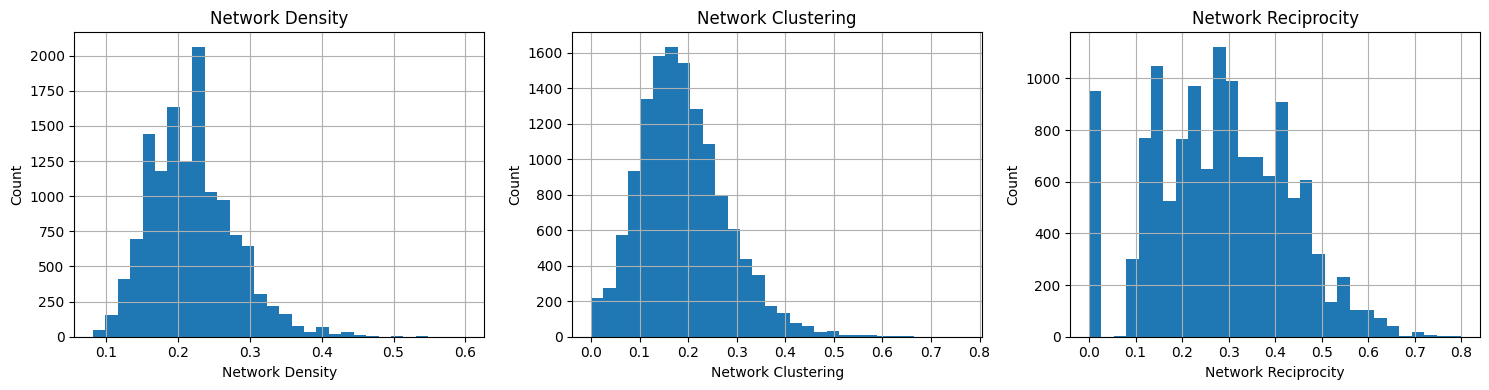

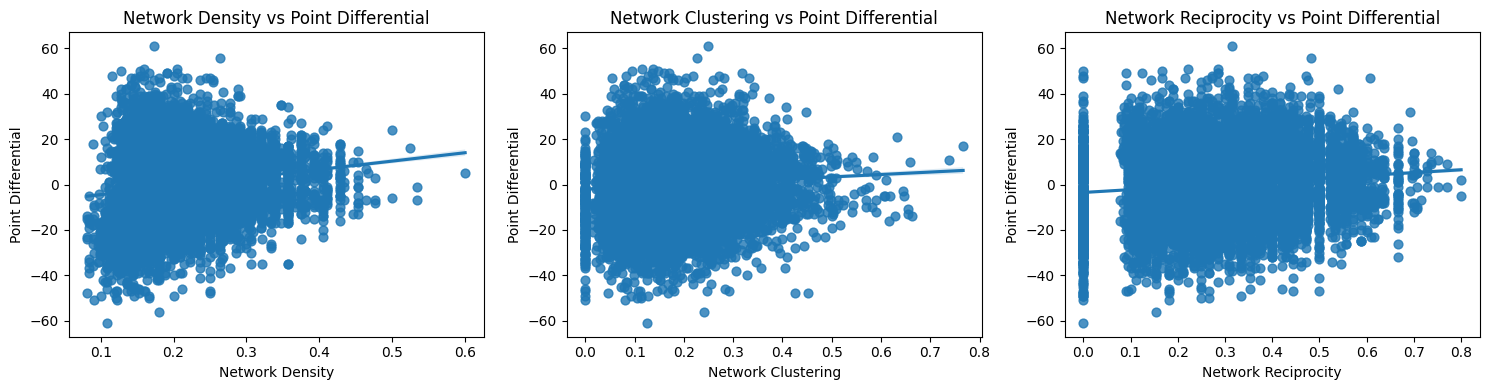

In [7]:
plot_rq1_histograms(team_metrics)
plot_rq1_scatter_relations(team_metrics)

## RQ2 — How do star departures affect network cohesion over time?

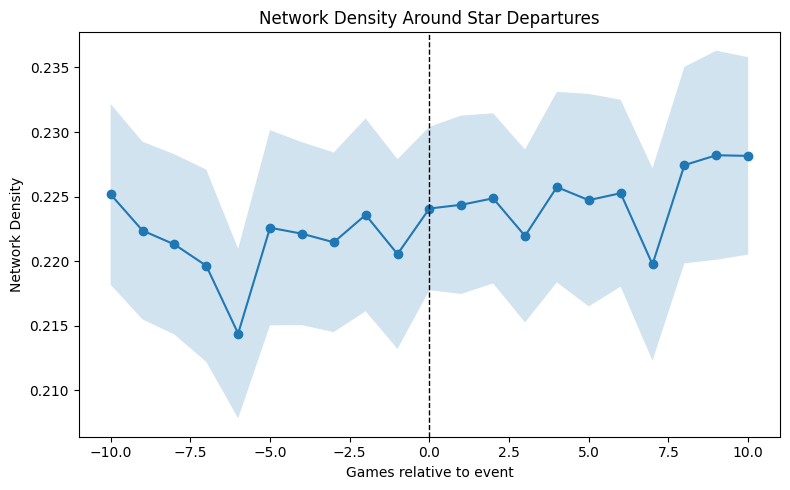

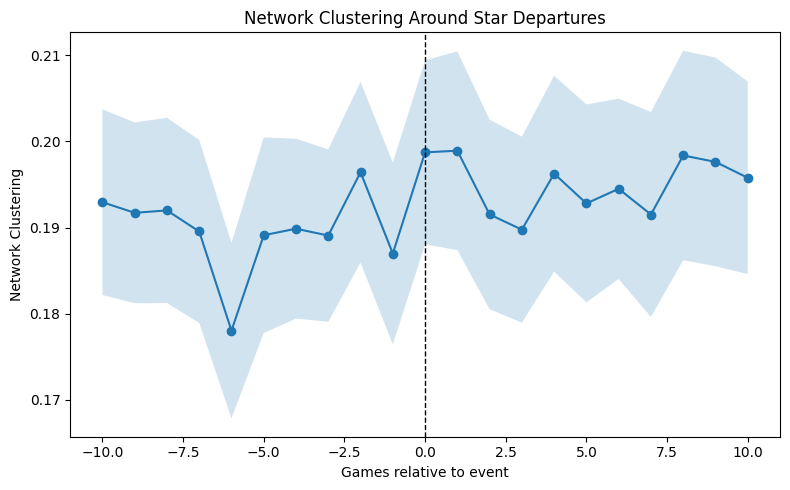

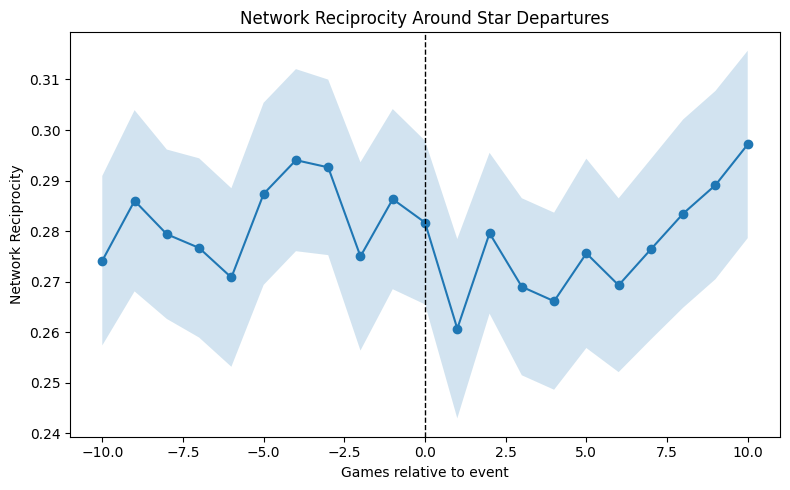

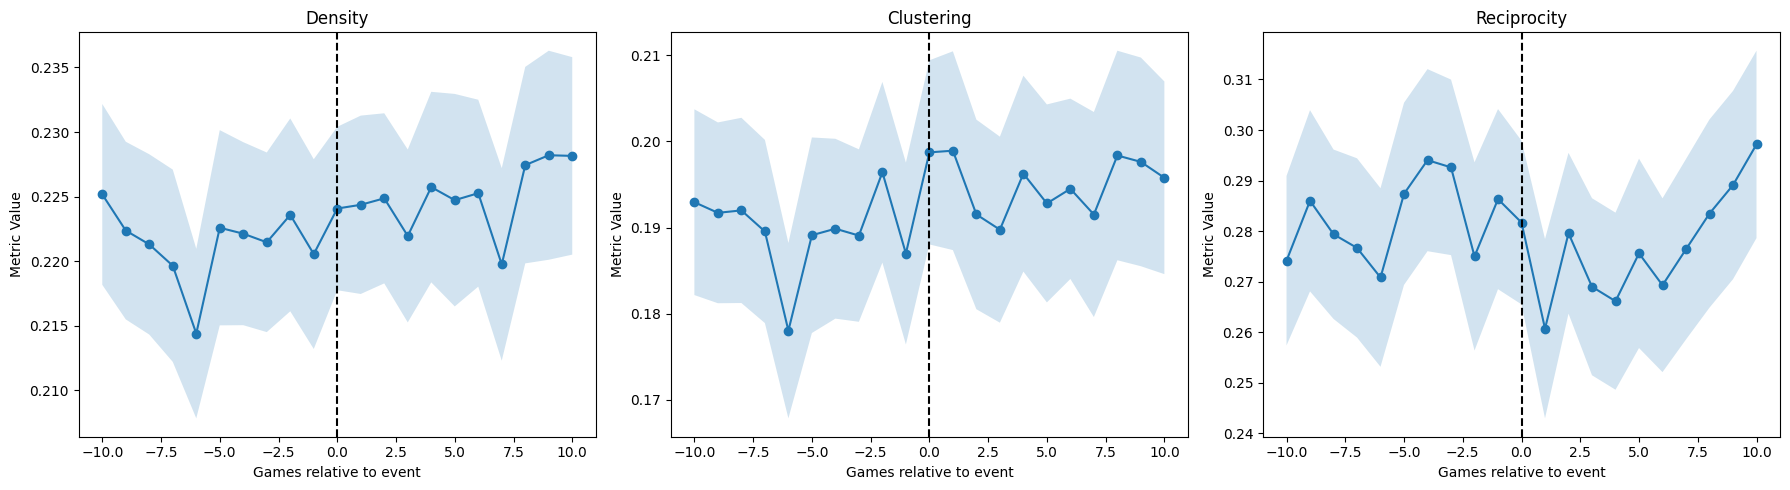

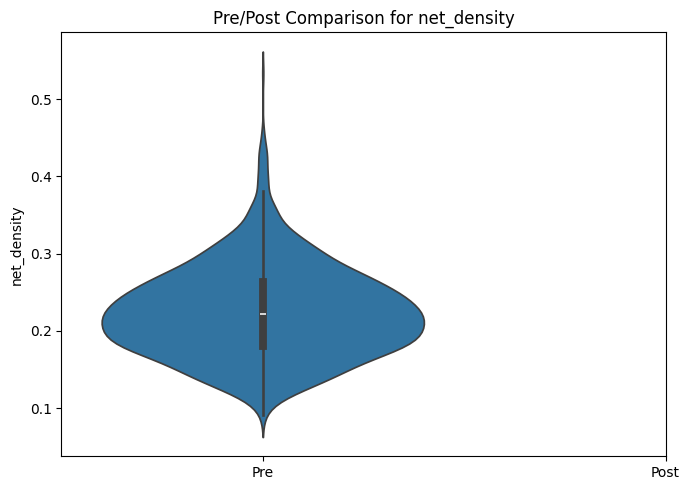

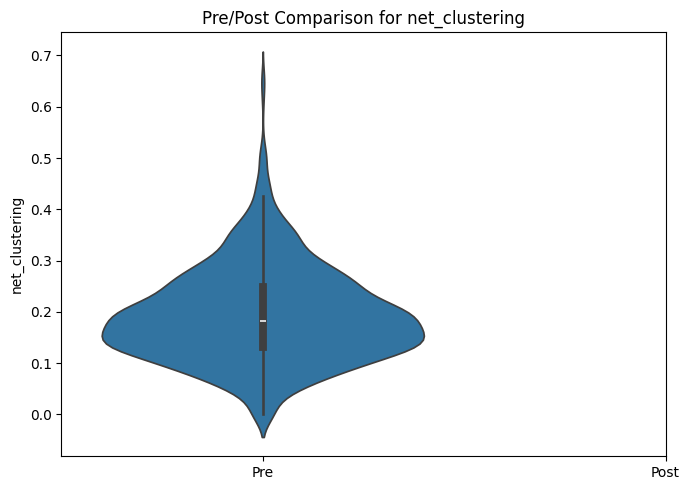

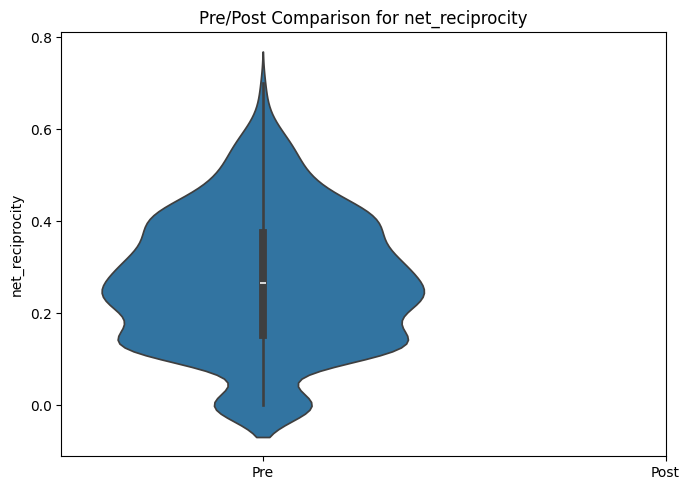

In [8]:
plot_rq2_ci(event_panel)
plot_rq2_facets(event_panel)
plot_rq2_pre_post(event_panel)

## RQ3 — Which network metrics best predict wins?

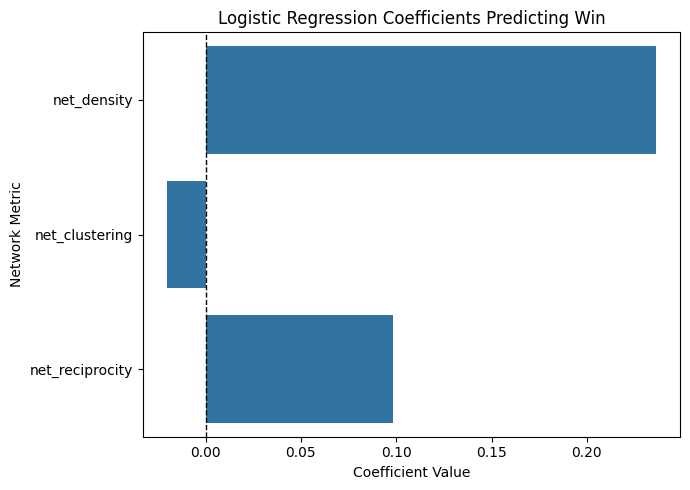

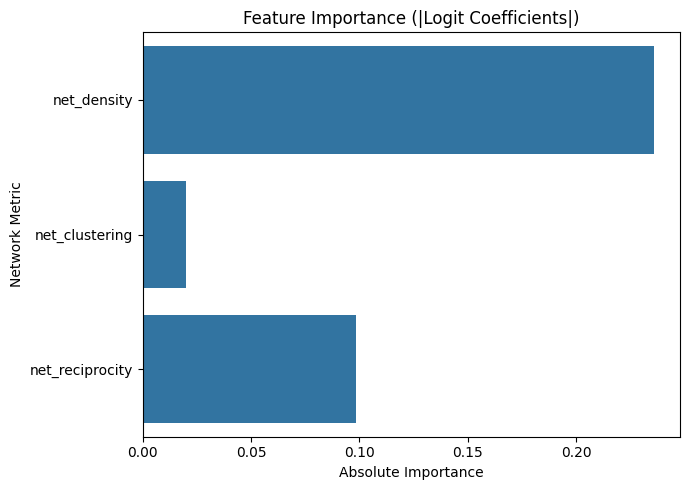

In [9]:
plot_rq3_logit_coefficients(team_metrics)
plot_rq3_feature_importance(team_metrics)